# Fire detection

## Imports

### Libraries

In [1]:
import os
import sys
import random
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import models

import numpy as np
from PIL import Image
import cv2 as cv

import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Local

In [2]:
from src.dataset import FireImageDataset
from src.utils.object_localization import BoundingBox, l_boxes_to_tensor
from src.nets.linear_detector import FireDetectionNetLinear
from src.nets.rnn_detector import FireDetectionNetRNN
from src.utils.hardware import device
from src.training import train, fire_detection_loss

## Data

### Preprocessing

Let us apply the following prproessing steps to the data:
* Resizing the images to 1280x720 (HD)
* Normalizing the pixel values to the range [0, 1]
* Random variation in brightness, contrast, and saturation

Addtionally, a noise reduction step is applied to the images while loading them in the [utils](./src/utils/image.py) directory.

In [3]:
# Preprocessing operations
image_dim = (224, 224)

preprocess = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly change the brightness, contrast, saturation, and hue
])

Loading the data:

In [4]:
# Define the data directories
DATA_DIR = os.path.join(os.getcwd(), 'data')
IMAGE_DIR = os.path.join(DATA_DIR, 'images')
LABEL_DIR = os.path.join(DATA_DIR, 'labels')

TRAIN_IMAGE_DIR = os.path.join(IMAGE_DIR, 'train')
TRAIN_LABEL_DIR = os.path.join(LABEL_DIR, 'train')
VAL_IMAGE_DIR = os.path.join(IMAGE_DIR, 'val')
VAL_LABEL_DIR = os.path.join(LABEL_DIR, 'val')

train_portion = 0.3
val_portion = 0.15

# Initialize the datasets
train_set = FireImageDataset(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR, transform=preprocess, portion=train_portion)
validation_set = FireImageDataset(VAL_IMAGE_DIR, VAL_LABEL_DIR, transform=preprocess, portion=val_portion)

# Verify that the image and label files are correctly paired
train_set.verify()
validation_set.verify()

Displaying size of the datasets:

In [5]:
print(f'Train set size: {len(train_set)}')
print(f'Validation set size: {len(validation_set)}')

Train set size: 1815
Validation set size: 229


### Example visualization

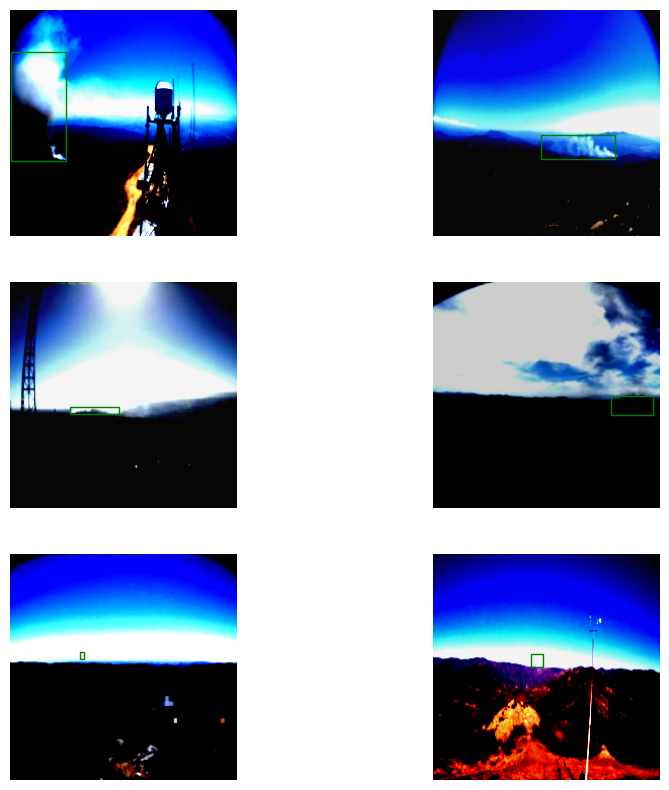

In [18]:
random.seed(20)
ax, fig = plt.subplots(3, 2, figsize=(10, 10))

# Display a sample image and label
for i in range(6):
    image, bbox = train_set[random.randint(0, len(train_set) - 1)]
    image = image.permute(1, 2, 0)
    i_fig = fig[i % 3, i // 3]
    i_fig.imshow(image)
    i_fig.axis('off')

    for j in range(len(bbox)):
        b_box = BoundingBox(bbox[j][0], bbox[j][1], bbox[j][2], bbox[j][3])
        i_fig.add_patch(b_box.plt_rectangle(image_width=image.shape[1], image_height=image.shape[0], color='g'))

plt.show()

### Loading

In [7]:
BATCH_SIZE = 4
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, collate_fn=train_set.collate_fn)
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, collate_fn=validation_set.collate_fn)

## Model(s)

### Architecture

For this part we may consider a custom model architecture for the fire (object) detection. The following architecture is inspired by the Yolo architecture, consisting of multiple heads for regression (bounding box prediction) and classification (fire detection). The implemented model architecture is defined in the [net](./src/nets/) directory, and is as follows:
* Backbone encoder: ResNet-50 (pretrained, frozen).
* RNN: 2-layer LSTM for bounding box prediction.
* Dropout: 0.4 rate for regularization.
* Bounding Box Head: Linear layer predicting 4 coordinates per box.
* Correctness Head: Two-layer fully connected network with softmax output for box correctness scores.

### Training - Transfer learning

In [8]:
num_supported_boxes = 5
model = FireDetectionNetRNN(num_supported_boxes=num_supported_boxes).to(device())
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(
    model=model,
    train_loader=train_loader,
    val_loader=validation_loader,
    criterion=fire_detection_loss,
    optimizer=optimizer,
    n_supported_boxes=num_supported_boxes,
    epochs=5
)

  0%|          | 0/453 [00:00<?, ?it/s]

/Users/francois.soulier/Desktop/Fire-Detection/src/utils/object_localization.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bbox_tensor[i][j] = torch.tensor(labels[i][j])


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.23625061006257028 | Validation Loss: 0.2372341569854703


  0%|          | 0/453 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.23040901202472444 | Validation Loss: 0.2334596454836916


  0%|          | 0/453 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.22974989808295385 | Validation Loss: 0.23444649512070234


  0%|          | 0/453 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.2295770142360824 | Validation Loss: 0.23326522268062075


  0%|          | 0/453 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.2292768902029873 | Validation Loss: 0.2335340666979161


### Visual quality - Short analysis

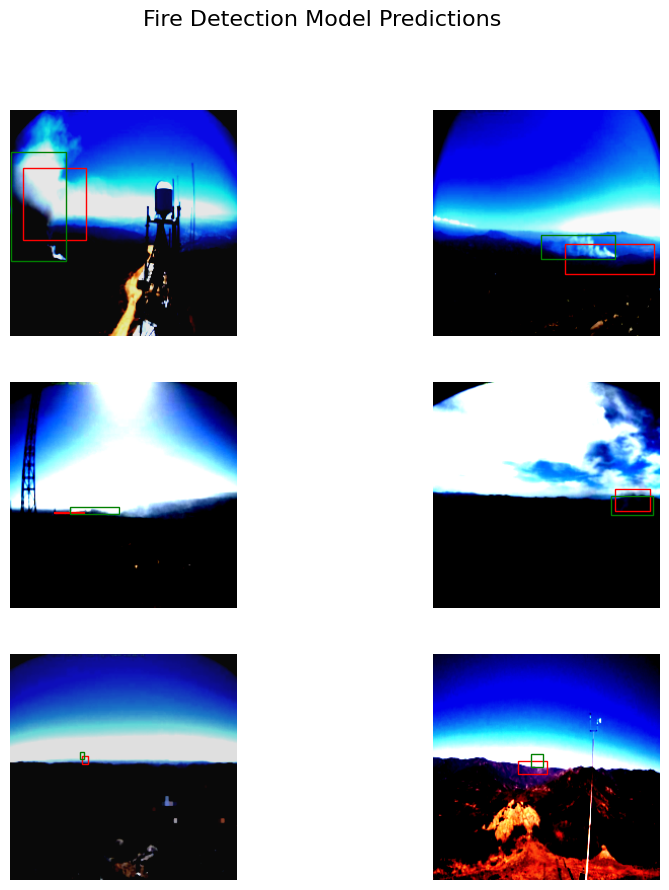

In [24]:
random.seed(20)
ax, fig = plt.subplots(3, 2, figsize=(10, 10))

# Display a sample image and label
for i in range(6):
    image, bbox = train_set[random.randint(0, len(train_set) - 1)]

    bboxes, correctness = model(image.unsqueeze(0).to(device()))
    bboxes, correctness = bboxes.squeeze().detach().cpu().numpy(), correctness.squeeze().detach().cpu().numpy()

    image = image.permute(1, 2, 0)
    i_fig = fig[i % 3, i // 3]
    i_fig.imshow(image)
    i_fig.axis('off')
    for j in range(len(correctness)):
        if correctness[j] > 0.85:
            b_box = BoundingBox(bboxes[j][0], bboxes[j][1], bboxes[j][2], bboxes[j][3])
            label_b_box = BoundingBox(bbox[j][0], bbox[j][1], bbox[j][2], bbox[j][3])
            i_fig.add_patch(b_box.plt_rectangle(image_width=image.shape[1], image_height=image.shape[0]))
            i_fig.add_patch(label_b_box.plt_rectangle(image_width=image.shape[1], image_height=image.shape[0], color='g'))

# Set the title of the plot
plt.suptitle('Fire Detection Model Predictions', fontsize=16)
plt.show()

From these few examples, we observe that the model is able to detect the location of the fire in the image. However, it lacks granularity in the bounding box prediction. In this above predictions, two cases, are observed:
* The bounding box is too large and includes a lot of background, because the object to detect appears to be very small in proportion.
* The bounding box truncates the object to detect, as shown on the two examples on the top of the two columns, even if the object is distinguishable from the background.

<u>**N.B**</u>:
* The model is not tested on the dataset in this notebook as it has not been training on a sufficient amount of data, and the architecture may not be robust enough for the object detection task. However, in later stages of the project development, the model ought to be tested on a different split of the dataset that the model has not seen before. This would allow for a more accurate evaluation of the model's generalization capabilities.
* Here is a list of the metrics that could be used to evaluate the model:
    * Intersection over Union (IoU): Ratio of the overlap area between the ground truth and the predicted bounding box over the union of their area.
    * Precision: Measures the model's ability to not label a negative sample as positive.
    * Recall: Measures the model's sensitivity to the positive class.
    * F1 score: Mean score of the precision and recall.
* Explainability: The model could be made more interpretable by using Grad-CAM or LIME to visualize the regions of the image that are most important for the model's prediction. Indeed, the model has a classification head that outputs the correctness of the bounding box, which could be used to visualize the regions of the image that are most important for the model's prediction.